In [1]:
import numpy as np
import random
import math
import heapq
import multiprocess as mp
import talib as ta
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
from chromosome import Chromosome 
from data_preprocessing import Data
from single_data_processing import SingleAssetTI
import itertools
import yfinance as yf
from pso import PortfolioPSO
from model_comparator import ModelComparator
from island_ga import IslandGGA
from single_data_processing import SingleAssetTI
from diversified_strategies import DiversifiedTradingStrategies
import datetime


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


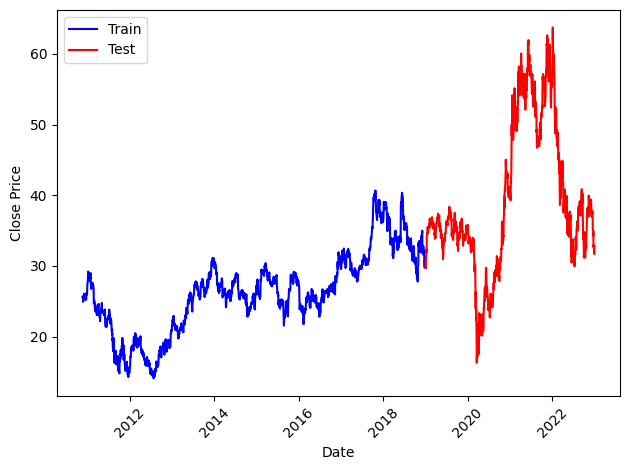

In [2]:
# Single stock  experiment
start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2022, 12, 31)
period ="train"
ticker = 'GM'
data = SingleAssetTI(ticker, start_date, end_date,2019)
data.data_preprocess()
train_data = data.train_data    
val_data = data.test_data
strategies = data.strategies

Testing K values: [5, 7, 9, 11, 13, 15, 17, 19]
Testing K = 5...
Initialized with 5 max workers for 5 islands
Running ring with 5 workers
System: CPU 22.6%, Memory 77.9%
Generation 1: Best fitness = 0.514231  Average Fitness = 0.333471
Generation 2: Best fitness = 0.514231  Average Fitness = 0.407179
Generation 3: Best fitness = 0.514231  Average Fitness = 0.409031
Generation 4: Best fitness = 0.514231  Average Fitness = 0.409901
Generation 5: Best fitness = 0.514231  Average Fitness = 0.415335
Performing migration
Generation 6: Best fitness = 0.514231  Average Fitness = 0.424149
Generation 7: Best fitness = 0.514231  Average Fitness = 0.470598
Generation 8: Best fitness = 0.514231  Average Fitness = 0.466210
Generation 9: Best fitness = 0.514231  Average Fitness = 0.471681
Generation 10: Best fitness = 0.514231  Average Fitness = 0.477285
System: CPU 14.1%, Memory 75.1%
Performing migration
Generation 11: Best fitness = 0.514231  Average Fitness = 0.477129
Generation 12: Best fitness 

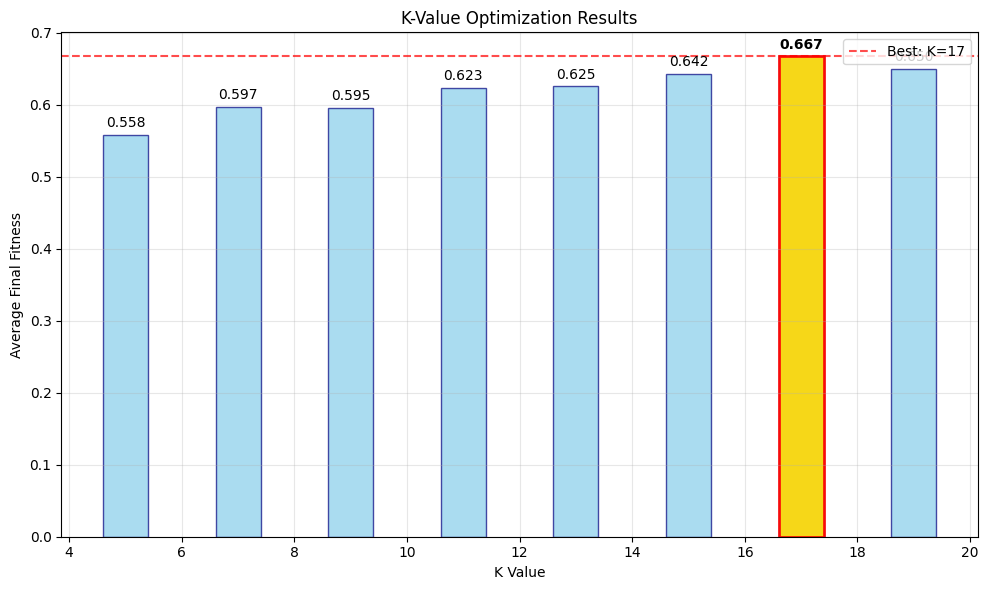


All results:
   K =  5: 0.5577
   K =  7: 0.5969
   K =  9: 0.5953
   K = 11: 0.6233
   K = 13: 0.6251
   K = 15: 0.6422
👑 K = 17: 0.6669
   K = 19: 0.6497

Recommendation: Use K = 17


In [3]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")


current_train = train_data
current_test = val_data
pSize = 150
num_iter = 30
m_iter = 5
num_islands = 5
Ks = list(range(5, 20, 2))
num_runs = 10

# Store results
results = []
fitness_values = []

print(f"Testing K values: {Ks}")

for k in Ks:
    print(f"Testing K = {k}...")
    
    final_values = []  # Store only final fitness values for each run
    
    for run in range(num_runs):
        gtsp = IslandGGA(
            data=current_train,
            K=k,
            num_islands=num_islands,
            m_iter=m_iter,
            num_iter=num_iter,
            pSize=pSize,
            strategies=strategies,
            evolve_strategy='ring'
        )
        
        gtsp.evolve()
        
        # Get only the final fitness value
        final_fitness = gtsp.convergence_values[-1]
        final_values.append(final_fitness)
        
        # Store for CSV
        results.append({
            'k_value': k,
            'run': run,
            'final_fitness': final_fitness
        })
    
    # Calculate average final performance for this K
    avg_final = np.mean(final_values)
    fitness_values.append(avg_final)
    
    print(f"  K = {k}: Average final fitness = {avg_final:.4f}")

# Save results to CSV
df = pd.DataFrame(results)
df.to_csv('results/k_results.csv', index=False)

# Find best K
best_k_idx = np.argmax(fitness_values)
best_k = Ks[best_k_idx]
best_fitness = fitness_values[best_k_idx]

print(f"\n🏆 BEST K VALUE: {best_k}")
print(f"   Average final fitness: {best_fitness:.4f}")

# Simple plot
plt.figure(figsize=(10, 6))
plt.bar(Ks, fitness_values, alpha=0.7, color='skyblue', edgecolor='navy')
plt.axhline(y=best_fitness, color='red', linestyle='--', alpha=0.7, label=f'Best: K={best_k}')

# Highlight best K
plt.bar(best_k, best_fitness, alpha=0.9, color='gold', edgecolor='red', linewidth=2)

plt.xlabel('K Value')
plt.ylabel('Average Final Fitness')
plt.title('K-Value Optimization Results')
plt.legend()
plt.grid(True, alpha=0.3)

# Add value labels on bars
for i, (k, fitness) in enumerate(zip(Ks, fitness_values)):
    plt.text(k, fitness + max(fitness_values)*0.01, f'{fitness:.3f}', 
             ha='center', va='bottom', fontweight='bold' if k == best_k else 'normal')

plt.tight_layout()
#plt.savefig('results/k_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

# Print simple summary
print(f"\nAll results:")
for k, fitness in zip(Ks, fitness_values):
    marker = "👑" if k == best_k else "  "
    print(f"{marker} K = {k:2d}: {fitness:.4f}")

print(f"\nRecommendation: Use K = {best_k}")

In [3]:
## Multi stock experiment
start_date = datetime.datetime(2020, 1, 1)
end_date = datetime.datetime(2022, 12, 31)
period =2022
tickers = [
        # Large cap stocks
        'AAPL', 'MSFT', 'GOOGL', 'TSLA', 'AMZN',
        # Different sectors
        'JPM', 'JNJ', 'PG', 'XOM', 'WMT',
        # ETFs for broader exposure
        'SPY', 'QQQ', 'IWM', 'EFA', 'GLD'
    ]

diversified_system = DiversifiedTradingStrategies(
            tickers=tickers,
            start_date=start_date,
            end_date=end_date,
            test_period=period
        )
    
# Generate training returns
print("Generating diversified training and tesing strategies...")
train_data, val_data = diversified_system.generate_diversified_returns(is_training=True)
strategies = diversified_system.strategy_names

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Loaded AAPL: 756 records
Loaded MSFT: 756 records


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Loaded GOOGL: 756 records
Loaded TSLA: 756 records


[*********************100%***********************]  1 of 1 completed


Loaded AMZN: 756 records


[*********************100%***********************]  1 of 1 completed


Loaded JPM: 756 records


[*********************100%***********************]  1 of 1 completed


Loaded JNJ: 756 records


[*********************100%***********************]  1 of 1 completed


Loaded PG: 756 records


[*********************100%***********************]  1 of 1 completed


Loaded XOM: 756 records


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Loaded WMT: 756 records
Loaded SPY: 756 records


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Loaded QQQ: 756 records
Loaded IWM: 756 records


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Loaded EFA: 756 records
Loaded GLD: 756 records
Generating diversified training and tesing strategies...


Testing K values: [5, 7, 9, 11, 13, 15, 17, 19]
Testing K = 5...
Initialized with 5 max workers for 5 islands
Running ring with 5 workers
System: CPU 2.6%, Memory 69.2%
Generation 1: Best fitness = 2.284036  Average Fitness = 1.183521
Generation 2: Best fitness = 2.284036  Average Fitness = 1.868745
Generation 3: Best fitness = 2.284036  Average Fitness = 1.878369
Generation 4: Best fitness = 2.284036  Average Fitness = 1.883221
Generation 5: Best fitness = 2.284036  Average Fitness = 1.921419
Performing migration
Generation 6: Best fitness = 2.284036  Average Fitness = 2.048464
Generation 7: Best fitness = 2.284036  Average Fitness = 2.219619
Generation 8: Best fitness = 2.284036  Average Fitness = 2.224433
Generation 9: Best fitness = 2.284036  Average Fitness = 2.220978
Generation 10: Best fitness = 2.425260  Average Fitness = 2.228000
System: CPU 2.4%, Memory 66.0%
Performing migration
Generation 11: Best fitness = 2.425260  Average Fitness = 2.270836
Generation 12: Best fitness = 

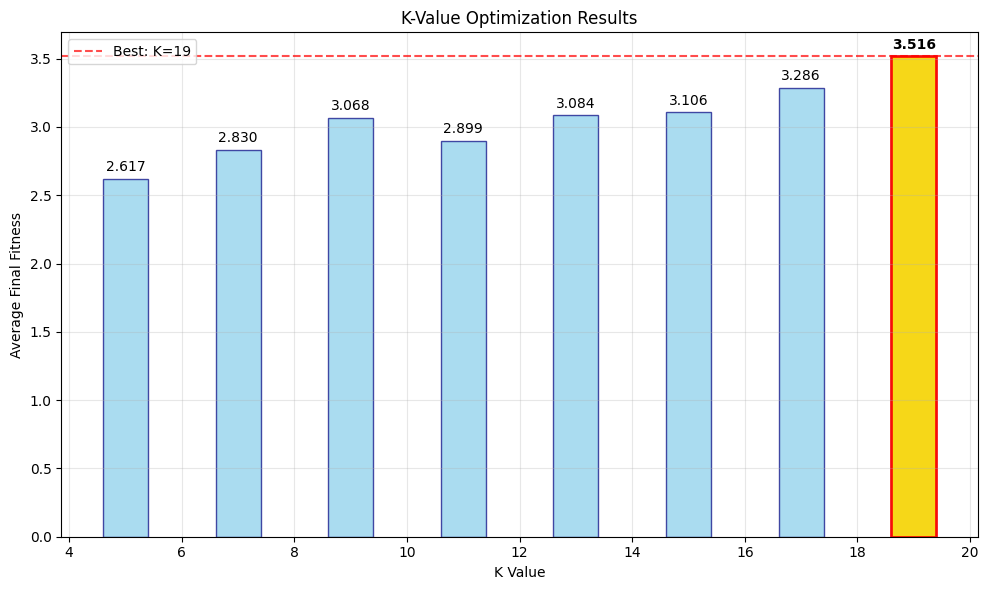


All results:
   K =  5: 2.6173
   K =  7: 2.8303
   K =  9: 3.0678
   K = 11: 2.8994
   K = 13: 3.0841
   K = 15: 3.1056
   K = 17: 3.2858
👑 K = 19: 3.5164

Recommendation: Use K = 19


In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")


current_train = train_data
current_test = val_data
pSize = 150
num_iter = 30
m_iter = 5
num_islands = 5
Ks = list(range(5, 20, 2))
num_runs = 10

# Store results
results = []
fitness_values = []

print(f"Testing K values: {Ks}")

for k in Ks:
    print(f"Testing K = {k}...")
    
    final_values = []  # Store only final fitness values for each run
    
    for run in range(num_runs):
        gtsp = IslandGGA(
            data=current_train,
            K=k,
            num_islands=num_islands,
            m_iter=m_iter,
            num_iter=num_iter,
            pSize=pSize,
            strategies=strategies,
            evolve_strategy='ring'
        )
        
        gtsp.evolve()
        
        # Get only the final fitness value
        final_fitness = gtsp.convergence_values[-1]
        final_values.append(final_fitness)
        
        # Store for CSV
        results.append({
            'k_value': k,
            'run': run,
            'final_fitness': final_fitness
        })
    
    # Calculate average final performance for this K
    avg_final = np.mean(final_values)
    fitness_values.append(avg_final)
    
    print(f"  K = {k}: Average final fitness = {avg_final:.4f}")

# Save results to CSV
df = pd.DataFrame(results)
df.to_csv('results/k_results_diversified.csv', index=False)

# Find best K
best_k_idx = np.argmax(fitness_values)
best_k = Ks[best_k_idx]
best_fitness = fitness_values[best_k_idx]

print(f"\n🏆 BEST K VALUE: {best_k}")
print(f"   Average final fitness: {best_fitness:.4f}")

# Simple plot
plt.figure(figsize=(10, 6))
plt.bar(Ks, fitness_values, alpha=0.7, color='skyblue', edgecolor='navy')
plt.axhline(y=best_fitness, color='red', linestyle='--', alpha=0.7, label=f'Best: K={best_k}')

# Highlight best K
plt.bar(best_k, best_fitness, alpha=0.9, color='gold', edgecolor='red', linewidth=2)

plt.xlabel('K Value')
plt.ylabel('Average Final Fitness')
plt.title('K-Value Optimization Results')
plt.legend()
plt.grid(True, alpha=0.3)

# Add value labels on bars
for i, (k, fitness) in enumerate(zip(Ks, fitness_values)):
    plt.text(k, fitness + max(fitness_values)*0.01, f'{fitness:.3f}', 
             ha='center', va='bottom', fontweight='bold' if k == best_k else 'normal')

plt.tight_layout()
#plt.savefig('results/k_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

# Print simple summary
print(f"\nAll results:")
for k, fitness in zip(Ks, fitness_values):
    marker = "👑" if k == best_k else "  "
    print(f"{marker} K = {k:2d}: {fitness:.4f}")

print(f"\nRecommendation: Use K = {best_k}")